In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import geopandas as gpd
from cartopy import config
from cartopy.feature import BORDERS
import cartopy.crs as ccrs
#import urllib.request
#import json 
import requests
from collections import defaultdict

In [3]:
venues_data = pd.read_csv('venues.csv')
calendar_data = pd.read_csv('calendar.csv')
demo_data = pd.read_csv('demographics.csv')
econ_state_data = pd.read_csv('econ_state.csv')
listings_data = pd.read_csv('listings.csv')
real_estate_data = pd.read_csv('real_estate.csv')

In [4]:
demo_data

,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,45-54_years,...,"$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000-$99,999","$100,000_or_more",median_household_income,mean_household_income
0,601,17982,17982,1006,1080,1342,1352,1321,2253,2149,...,48.1,12,12.8,8.6,8.7,6.2,1.4,16.3,10816,20349
1,602,40260,40260,2006,2440,2421,2953,2865,5124,5139,...,31.4,16.3,17.9,12.2,10.6,7.7,2.9,21.2,16079,23282
2,603,52408,52408,2664,3177,3351,3685,3585,6473,6775,...,31,14.9,17.5,11.7,10.8,8.7,2.4,21.9,16804,26820
3,606,6331,6331,347,331,461,474,469,707,933,...,45.3,10.2,20,11.7,11,1.8,0,12.8,12512,15730
4,610,28328,28328,1438,1490,2044,2122,1985,3358,3778,...,26.9,14.8,23.7,15.2,9.3,7.5,1.6,18.4,17475,23360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,99923,13,13,0,0,0,0,0,0,0,...,0,46.2,53.8,0,0,0,0,0,-,N
33116,99925,826,826,65,50,47,36,60,86,82,...,7.1,6.2,21.2,11.1,12.6,17.5,9.5,39.6,38594,52706
33117,99926,1711,1711,161,124,140,113,107,224,182,...,5.5,1.9,14.1,11.1,16.8,14.5,12,43.3,51071,71580
33118,99927,123,123,0,0,0,0,0,0,32,...,28.2,0,23.1,15.4,25.6,0,0,25.6,19861,35617


In [5]:
#Note that listings, real_estate, demo_data contain zip code data
#listings may not be worth it??
zip_codes = gpd.read_file('tl_2019_us_zcta510/tl_2019_us_zcta510.shp')
counties = gpd.read_file('cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
state_fips = pd.read_csv('state_fips.csv')[['Name', 'Postal Code', 'FIPS']]
counties['FIPS'] = counties['STATEFP'].astype('int32')

In [6]:
counties = counties.merge(state_fips, on='FIPS', how='left')
real_estate_data.columns

Index(['type', 'zipcode', 'city', 'state', 'metro', 'county', 'size_rank',
       '1996-04', '1996-05', '1996-06',
       ...
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06'],
      dtype='object', length=262)

In [7]:
real_estate_counties = counties.merge(real_estate_data, left_on=['NAME', 'Postal Code'], right_on=['county', 'state'])
real_estate_counties['2014-09']

0          841
1          838
2          842
3          886
4          960
         ...  
28194    91000
28195    85500
28196    92500
28197    89400
28198    86800
Name: 2014-09, Length: 28199, dtype: int64

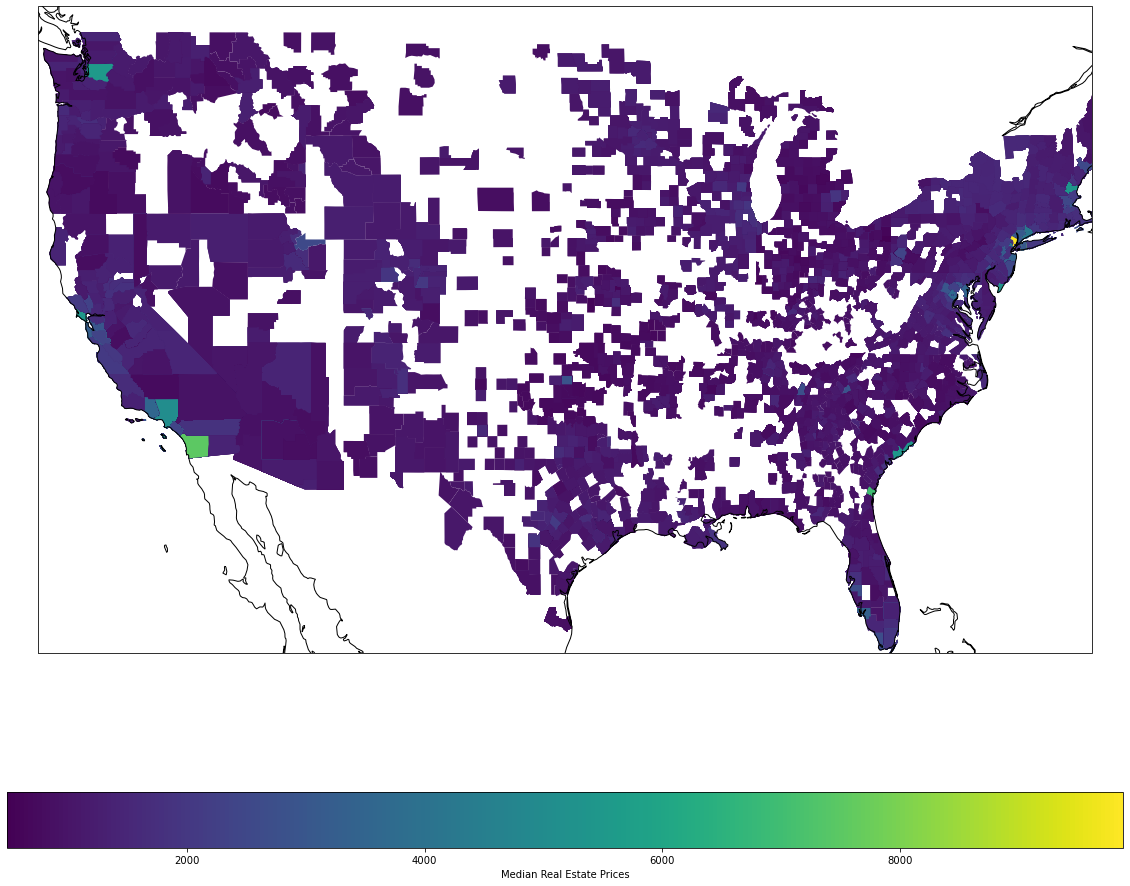

In [8]:
month_year = '2012-09'
fig1, ax1 = plt.subplots(figsize=(20,17))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
real_estate_counties.query('`{}` < 10000'.format(month_year)).plot(column=month_year, cmap='viridis', ax=ax1, legend=True, legend_kwds={'label': 'Median Real Estate Prices', "orientation": "horizontal"})#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))
plt.savefig('housing_prices_heatmap_{}.png'.format(month_year))

In [9]:
zip_codes.head()
zip_codes['zipcode'] = zip_codes['ZCTA5CE10'].astype('int32')
zip_codes = gpd.read_file('tl_2019_us_zcta510/tl_2019_us_zcta510.shp')

In [10]:
#demo_zip = zip_codes.merge(demo_data, on='zipcode')#, how='right')
#estate_zip = zip_codes.merge(real_estate_data.groupby('zipcode').mean(), on='zipcode')
listings_data.groupby('city').count().rsub(listings_data.groupby('city').size(), axis=0)['weekly_price'].sort_values().tail(20)

city
culver city          187
lakewood             191
burbank              195
arcadia              212
redondo beach        235
lawndale             263
venice               290
rowland heights      296
malibu               318
Asheville            325
beverly hills        391
playa del rey        443
south pasadena       619
santa monica         764
west hollywood       781
hermosa beach        975
nashville           2270
New Orleans         4530
austin              7770
los angeles        14863
Name: weekly_price, dtype: int64

In [11]:
#Create aggregated datasets for listings etc. 
print(listings_data)
#agg_listings = listings_data.groupby('zipcode').mean()
#print(listings_data['zipcode'])

       accommodates                                          amenities  \
0               2.0  {"Wireless Internet","Air Conditioning",Kitche...   
1               4.0  {TV,"Cable TV",Internet,"Wireless Internet","A...   
2               1.0  {TV,"Wireless Internet","Air Conditioning",Kit...   
3               6.0  {Internet,"Wireless Internet","Air Conditionin...   
4               6.0  {Internet,"Wireless Internet","Free Parking on...   
...             ...                                                ...   
50316           2.0  {TV,"Cable TV","Wireless Internet","Pets live ...   
50317           2.0  {"Wireless Internet",Kitchen,"Free parking on ...   
50318          10.0  {TV,"Wireless Internet","Air conditioning",Kit...   
50319           4.0  {TV,Internet,"Wireless Internet","Air conditio...   
50320           8.0  {TV,"Wireless Internet","Air conditioning",Kit...   

       availability_30  bathrooms  bed_type  bedrooms  beds  \
0                    0        1.0  Real Bed     

NameError: name 'demo_zip' is not defined

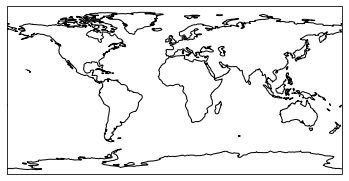

In [12]:
fig1, ax1 = plt.subplots()
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
print(demo_zip.columns)
demo_zip.plot(column='$100,000_or_more', cmap='viridis', ax=ax1)#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))

NameError: name 'estate' is not defined

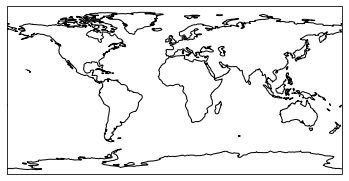

In [13]:
fig1, ax1 = plt.subplots()
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
estate.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))

In [14]:
#tidy the real estate data
real_estate_tidy = real_estate_data.melt(id_vars=['type', 'zipcode', 'city', 'state', 'metro', 'county', 'size_rank'],var_name='date', value_name='monthly_avg_price')

In [15]:
real_estate_tidy.head()

,type,zipcode,city,state,metro,county,size_rank,date,monthly_avg_price
0,ZHVI,10025,New York,NY,New York,New York,1,1996-04,NaN
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,1996-04,146700.0
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,1996-04,198000.0
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,1996-04,70800.0
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,1996-04,102300.0


In [16]:
#tidy the demographic data into two 
print(demo_data.columns)
demo_data_tidy = demo_data.melt(id_vars=['zipcode', 'population', 'households', 'median_household_income', 'mean_household_income'], var_name = 'ranges', value_name = 'counts')

Index(['zipcode', 'population', '5_years_or_less', '5-9_years', '10-14_years',
       '15-19_years', '20-24_years', '25-34_years', '35-44_years',
       '45-54_years', '55-59_years', '60-64_years', '65-74_years',
       '75-84_years', '85_years_or_more', 'households', '$9,999_or_less',
       '$10,000-$14,999', '$15,000-$24,999', '$25,000-$34,999',
       '$35,000-$49,999', '$50,000-$64,999', '$65,000-$74,999',
       '$75,000-$99,999', '$100,000_or_more', 'median_household_income',
       'mean_household_income'],
      dtype='object')


In [17]:
demo_data_tidy.head()
demo_data_tidy['range_type'] = demo_data_tidy['ranges'].apply(lambda x: 'income_range' if x[0] == '$' else 'age_range')

440131      $9,999_or_less
473251     $10,000-$14,999
506371     $15,000-$24,999
539491     $25,000-$34,999
572611     $35,000-$49,999
605731     $50,000-$64,999
638851     $65,000-$74,999
671971     $75,000-$99,999
705091    $100,000_or_more
Name: ranges, dtype: object
440131    2682
473251     7.9
506371     6.4
539491    16.9
572611     9.2
605731    10.9
638851    12.2
671971     8.2
705091    31.3
Name: counts, dtype: object


<BarContainer object of 9 artists>

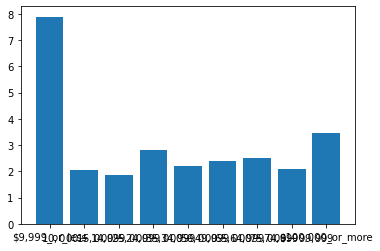

In [18]:
temp_demo = demo_data_tidy.query('zipcode == 30002 & range_type == "income_range"')
print(temp_demo['ranges'])
print(temp_demo['counts'])
plt.bar(height=np.log(temp_demo['counts'].astype('float64')), x=temp_demo['ranges'])
#demo_data_tidy

0      13.0
1       NaN
2     163.0
3     613.0
4     339.0
5       NaN
6      40.0
7     713.0
8     182.0
9     921.0
9       1.0
9       1.0
10      9.0
11    753.0
12     93.0
13    780.0
14    385.0
15     82.0
16      8.0
17     18.0
18    134.0
Name: city, dtype: float64


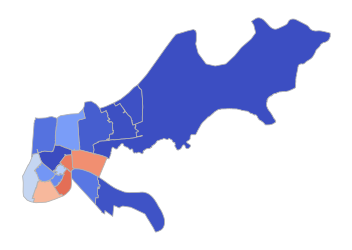

In [424]:
#Here's a calculation of how many AirBnb houses lie in a particular zip code
#first, merge aggregated zipcodes with Austin (or whatever city) shapefile
#lol, before we go too far we should double check LA to see if the methodology is correct
listings_counts = listings_data.groupby('zipcode').count()['city']
listings_counts = listings_counts[:-1]
listings_counts.index = listings_counts.index.str[:5].astype('float64')
#city_zipcodes = gpd.read_file('austin/austin_area_zip_codes.shp')
#city_zipcodes = gpd.read_file('nashville/geo_export_ce95ea06-82ce-4673-82c7-c568df5a3eec.shp')
#city_zipcodes = gpd.read_file('la/b982f3c3-ffe6-4e4a-b8e6-2bd1eb2c70642020328-1-26h3sc.00ox.shp')
city_zipcodes = gpd.read_file('nola/geo_export_82c5f368-18be-4714-b4da-8f8faa2ab177.shp')
city_zipcodes['zipcode'] = city_zipcodes['zcta5ce10'].astype('float64')
#city_zipcodes['zipcode'] = city_zipcodes['zipcode'].astype('float64')
#city_zipcodes['zipcode'] = city_zipcodes['zip'].astype('float64')
#city_zip_counts = city_zipcodes.merge(listings_counts, how='left', left_on='zip', right_index=True)
city_zip_counts = city_zipcodes.merge(listings_counts, how='left', left_on='zipcode', right_index=True)
print(city_zip_counts['city'])

#then plot graph as shown below
data = city_zip_counts
na = data[pd.isna(data['city'])]
#data
fig, ax = plt.subplots(1, figsize=(5,5))
ax.axis('off')
na.plot(color='white', linewidth=0.8, ax=ax, edgecolor='0.7')
data.plot(column='city', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.7')
fig.tight_layout()
city = 'miami'
feature = 'listings'
fig.savefig(city+'_'+feature+'.png', format='png', dpi=1000)
plt.show()

In [406]:
#Now, let's see if we can try to fetch gentrification data and retrieve a similar plot afterwards...
demo_millenial = demo_data_tidy.query('ranges == "25-34_years" & population > 0')
#print(demo_data_tidy.tail()) 
#four components of score: age proportion growth, education level growth, median income growth, median gross rent growth, 
#honestly I think comparing 2011 to 2019 levels should be fine, this is recent data after all...
#year = '2011'

#State fips number
#southern_states_fips = ['10', '11', '12', '13', '24', '37', '45', '51', '54', '01', '21', '28', '47', '05', '22', '40', '48', '02']
southern_states_fips = ['10', '11', '12', '13', '24', '37', '45', '51', '54', '01', '21', '28', '47', '05', '22', '40', '48']#, '02']
#['01', 2, 37, 40, 10, 12, 13, 45, 47, 48, 51, 21, 22, 54, 24, 28}
data_dicts = defaultdict(lambda: defaultdict())
for state_no in southern_states_fips:
    print(state_no)
    for ind, year in enumerate(['2011', '2012', '2013', '2016', '2017', '2018']):
        data_dict = defaultdict(lambda: [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        #median household income (12 is median, 13 is mean)
        median_income_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1901_C01_012E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
        mean_income_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1901_C01_013E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
        #median gross rent
        rent_url = 'https://api.census.gov/data/{}/acs/acs5?get=NAME,B25064_001E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
        #25 years and older with bachelor's degree or higher
        edu_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1501_C0{}_015E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
        #25-34, split into two groups
        #age_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_007E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
        #age_url_2 = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_008E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
        for i, url in enumerate([median_income_url, mean_income_url, rent_url, edu_url]):#, edu_url, age_url_2]):
            data = requests.get(url).json()
            #with urllib.request.urlopen(url) as open_url:
                #data = json.loads(open_url.read().decode())
            for row in data[1:]:
                data_dict[int(row[3])][i] = float(row[1]) #second part of age bracket
        data_dicts[state_no][year] = data_dict

10
11
12
13
24
37
45
51
54
01
21
28
47
05
22
40
48


In [430]:
#calculate gentrification scores based off of above code
scores = []
#state_code = '48' #Texas
state_code = '22' #Louisiana
for zipcode in data_dicts[state_code]['2011']:
    gent_score = 0
    #print(zipcode, i)
    #print(data_dicts[0][zipcode])
    #print(data_dicts[1][zipcode])
    to_append = [str(zipcode)]
    for i in range(4):
        if data_dicts[state_code]['2011'][zipcode][i] <= 0 or data_dicts[state_code]['2017'][zipcode][i] <= 0:
            continue
        to_append.append(data_dicts[state_code]['2011'][zipcode][i])
        to_append.append(data_dicts[state_code]['2017'][zipcode][i])
        #percentile_change = (data_dicts[1][zipcode][i] - data_dicts[0][zipcode][i]) / data_dicts[0][zipcode][i]
        #percentile_change = data_dicts[1][zipcode][i]# - data_dicts[0][zipcode][i]
        #gent_score += percentile_change /4
    scores.append(to_append)
score_data = pd.DataFrame(scores, columns=['zipcode', 'income2011', 'income2017', 'rent2011', 'rent2017', 'edu2011', 'edu2017'])
score_data['gentscore2011'] = (score_data['income2011'].rank(pct=True) + score_data['rent2011'].rank(pct=True))/2
score_data['gentscore2017'] = (score_data['income2017'].rank(pct=True) + score_data['rent2017'].rank(pct=True))/2
score_data['gentrification_score'] = score_data['gentscore2017'] - score_data['gentscore2011']

In [431]:
score_data

,zipcode,income2011,income2017,rent2011,rent2017,edu2011,edu2017,gentscore2011,gentscore2017,gentrification_score
0,70782,60729.0,24459.0,55203.0,35436.0,NaN,NaN,0.720993,0.047916,-0.673077
1,70785,63019.0,59959.0,68796.0,73170.0,644.0,780.0,0.883406,0.817165,-0.066241
2,70003,57140.0,55839.0,70592.0,72067.0,873.0,882.0,0.856095,0.785050,-0.071046
3,70006,53868.0,62532.0,72683.0,84202.0,977.0,984.0,0.841040,0.892898,0.051857
4,70031,58177.0,72955.0,68131.0,72948.0,NaN,NaN,0.850462,0.878523,0.028061
...,...,...,...,...,...,...,...,...,...,...
510,71367,51974.0,40759.0,59493.0,50907.0,NaN,NaN,0.722480,0.351609,-0.370871
511,71403,46277.0,55592.0,59091.0,77383.0,525.0,710.0,0.650602,0.814876,0.164275
512,71414,28750.0,14688.0,33635.0,34798.0,914.0,555.0,0.082752,0.019110,-0.063642
513,71419,38344.0,41417.0,50410.0,53823.0,531.0,347.0,0.391363,0.401216,0.009854


In [438]:
#Populate metro_zipcodes dictionary with corresponding zipcodes
#{'Nashville': [37211, 37013, ...], 'Austin': [78613,78704,78745...]}
metro_zipcodes = {}
for index, row in real_estate_data.iterrows():
    if (row['metro'] not in metro_zipcodes):
        temp_list = [row['zipcode']]
        metro_zipcodes[row['metro']] = temp_list
    else:
        temp_list_2 = metro_zipcodes[row['metro']]
        temp_list_2.append(row['zipcode'])
        metro_zipcodes[row['metro']] = temp_list_2

In [437]:
#The Ellen & O’Regan model calls an area “gentrified” if the ratio of the neighb
#household income at the start of the decade, compared to the metro average hous
#income, is less than 0.7—and there needs to be at least a 10 percentage-point i
#in the ratio of neighborhood to metro average household income over the past de
def gentrification_score(zipcode, fips):
    fips = '{0:02d}'.format(fips)
    if zipcode == None:
        return np.nan #edge case
    
    this_zip = demo_data[demo_data.zipcode == zipcode]
    # mean income for a zipcode (aka neighborhood)
    #average_neighborhood_income = this_zip["mean_household_income"]
    mean_nbr_inc_1 = sum([data_dicts[fips][year][zipcode][0] for year in ['2011', '2012', '2013']])/3
    mean_nbr_inc_2 = sum([data_dicts[fips][year][zipcode][0] for year in ['2016', '2017', '2018']])/3
    #mean_nbr_inc_1 = sum([data_dicts[fips][year][zipcode][0] for year in ['2011']])/1
    #mean_nbr_inc_2 = sum([data_dicts[fips][year][zipcode][0] for year in ['2016']])/1
    if mean_nbr_inc_1 < 0 or mean_nbr_inc_2 < 0:
        return np.nan #unclean sum
    #average_neighborhood_income = data_dicts[1][zipcode][0] - data_dicts[0][zipcode][0]
    average_neighborhood_income = mean_nbr_inc_2 - mean_nbr_inc_1
    #average_neighborhood_income = pd.to_numeric(average_neighborhood_income, errors='coerce') #fill with nans for invalid input

    # mean income for a metro area
    metro_name = getMetro(zipcode)
    average_metro_income = getMetroIncome(metro_name, fips)
    if average_metro_income == np.nan:
        return np.nan
    #if len(average_neighborhood_income) == 0:
        #return np.nan #no data found
    
    #print(average_neighborhood_income, average_metro_income)

    # ratio of mean income for a zipcode/mean income for a metro area
    #print(average_neighborhood_income, average_metro_income, metro_name)
    return average_neighborhood_income/average_metro_income
    #return ((average_neighborhood_income/average_metro_income).values)[0]

#given a zipcode, get the metro name
def getMetro(zipcode):
    for k, v in metro_zipcodes.items():
        if zipcode in metro_zipcodes[k]:
            return (k)
    
#given a metro, get the average income for all zipcodes corresponding to that metro
def getMetroIncome(metro, fips):
    average_metro_income = 0
    if metro not in metro_zipcodes:
        return np.nan #better than crashing
    total_len = 0
    for zipcode in metro_zipcodes[metro]:
        '''
        this_zip = demo_data[demo_data.zipcode == zipcode]
        if len(this_zip['mean_household_income']) == 0: #probably not found
            #print(this_zip)
            continue #we should skip this one
        average_metro_income = average_metro_income + float(this_zip["mean_household_income"])
        total_len += 1
        '''
        if zipcode not in data_dicts[fips]['2011']:
            continue
        mean_house_inc_1 = sum([data_dicts[fips][year][zipcode][0] for year in ['2011', '2012', '2013']])/3
        mean_house_inc_2 = sum([data_dicts[fips][year][zipcode][0] for year in ['2016', '2017', '2018']])/3
        #mean_house_inc_1 = sum([data_dicts[fips][year][zipcode][0] for year in ['2011']])/1
        #mean_house_inc_2 = sum([data_dicts[fips][year][zipcode][0] for year in ['2016']])/1
        if mean_house_inc_1 < 0 or mean_house_inc_2 < 0:
            continue #this means there was some invalid values
        #print(zipcode, mean_house_inc_1, mean_house_inc_2)
        average_metro_income += mean_house_inc_2 - mean_house_inc_1
        total_len += 1
        #average_metro_income += mean_house_inc
    average_metro_income = average_metro_income/total_len
    return average_metro_income

In [385]:
#gentrification_score(78739)

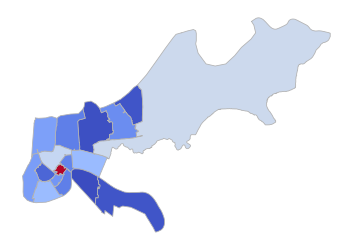

In [444]:
#Now plot the desired figure
#print(type(city_zipcodes['zip']))
score_data['zipcode'] = score_data['zipcode'].astype('float64')
#print(score_data)
zip_scores = city_zipcodes.merge(score_data, how='left', left_on='zipcode', right_on='zipcode')
#zip_scores['gent_perc'] = zip_scores['gentrification_score'].rank(pct=True)
#city_zipcodes['gentrification_score'] = city_zipcodes['zipcode'].astype('int32').map(lambda code: gentrification_score(code, 22))
#print(city_zipcodes)

#then plot graph as shown below
data = zip_scores
#data = city_zipcodes
na = data[pd.isna(data['gentrification_score_y'])]
#data
fig, ax = plt.subplots(1, figsize=(5,5))
ax.axis('off')
na.plot(color='white', linewidth=0.8, ax=ax, edgecolor='0.7')
data.plot(column='gentrification_score_y', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.7')
fig.tight_layout()
city = 'la'
feature = 'gent_score'
fig.savefig(city+'_'+feature+'.png', format='png', dpi=1000)
plt.show()

In [352]:
demo_data['mean_household_income'] = pd.to_numeric(demo_data['mean_household_income'], errors='coerce')
southern_states = ['MD', 'DE', 'VA', 'WV', 'KY', 'TN', 'NC', 'SC', 'FL', 'GA', 'AL', 'MS', 'LA', 'AR', 'TX', 'OK']
#df.apply(lambda x: some_func(a = x['a'], b = x['b'], c = x['c']), axis=1)
#real_estate_data
real_estate_south = real_estate_data[real_estate_data['state'].isin(southern_states)].merge(state_fips, left_on='state', right_on='Postal Code', how='left')
print({i for i in real_estate_south['FIPS']})

ellen_zipscores = real_estate_south[['zipcode', 'FIPS']]
#ellen_zipscores['gentrification_score'] = real_estate_south['zipcode'].astype('int32').map(lambda code: gentrification_score(code))
ellen_zipscores['gentrification_score'] = ellen_zipscores.apply(lambda x: gentrification_score(x['zipcode'], x['FIPS']), axis=1)

{1, 37, 5, 40, 10, 12, 13, 45, 47, 48, 51, 21, 22, 54, 24, 28}


/Users/nicholaslai/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [357]:
ellen_zipscores.to_csv('southern_gentrification_scores.csv')
ellen_zipscores

,zipcode,FIPS,gentrification_score
0,79936,48,3.749817
1,77084,48,0.679543
2,75070,48,NaN
3,77449,48,1.512082
4,32162,12,NaN
...,...,...,...
10058,29074,45,NaN
10059,21840,24,4.283792
10060,29915,45,8.459861
10061,20687,24,-13.503183


In [ ]:
#State fips number
state_no = '47'
data_dicts = []
for ind, year in enumerate(['2011', '2017']):
    data_dict = defaultdict(lambda: [np.nan, np.nan, np.nan, np.nan])
    #median household income (first is median, second is mean)
    income_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1901_C01_012E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
    #median gross rent
    rent_url = 'https://api.census.gov/data/{}/acs/acs5?get=NAME,B25064_001E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
    #25 years and older with bachelor's degree or higher
    edu_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1501_C0{}_015E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    #25-34, split into two groups
    age_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_007E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    age_url_2 = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_008E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    for i, url in enumerate([income_url, rent_url, edu_url, age_url_2]):
        with urllib.request.urlopen(url) as open_url:
            data = json.loads(open_url.read().decode())
            for row in data[1:]:
                data_dict[int(row[3])][i] = float(row[1]) #second part of age bracket
    data_dicts.append(data_dict)